<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для интернет-магазина «Викишоп»

**Проект:  Проект для интернет-магазина «Викишоп»**
_____
**Описание исследования.**
    
К нам обратился интернет-магазин «Викишоп», который запускает новый сервис для того, чтобы пользователи могли редактировать и дополнять описания товаров, как в вики-сообществах. Клиенты будут предлагать свои правки и комментировать изменения других. Заказчику нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
_____
**Цель исследования.**
    
Построить модель для оценки тональности текста для полной или частичной автоматизации модерации.
    
_____
**Задачи исследования.**

Для того, чтобы достичь поставленной цели необходимо решить ряд задач:

- подготовить данные, которые нам предоставил заказчик;
- провести анализ полученных данных (проверить данные на наличие ошибок, найти закономерности);
- построить модель, качество которой будет удовлетворять требованиям заказчика;
- протестировать полученную модель на тестовой выборке и сделать выводы.
_____
**Исходные данные.**
    
Заказчиком были переданы данные в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
#!pip install imbalanced-learn -q
#!pip install wordcloud
#!pip install swifter - q
#!pip install xgboost
#!pip install urlextract

In [2]:
import pandas as pd
from tqdm import notebook
import re
from time import time 
import torch
import swifter
import transformers
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import numpy as np
from numpy.random import default_rng
import transformers
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report, make_scorer
from __future__ import unicode_literals, print_function
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import FixedThresholdClassifier, TunedThresholdClassifierCV
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
from urlextract import URLExtract

In [4]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
RANDOM_STATE = 88

## Подготовка

In [7]:
url = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

In [8]:
df = pd.read_csv(url)

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Импортировал данные `toxic_comments.csv` с исходными данными.

</font></div>

In [9]:
df.head()

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Вывел информацию о полученном датафрейме: типы данных корректные, пропусков нет.

</font></div>

In [11]:
df.drop('Unnamed: 0', axis=1, inplace=True)

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Удалил столбец `Unnamed: 0`.

</font></div>

In [12]:
df['text'].duplicated().sum()

0

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Проверил, есть ли в данных явные дубликаты - явных дубликатов не обнаружил.

</font></div>

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [14]:
def nl_split(string):
    
    string = re.split('\n+',string)
    result = [sent_tokenize(i.strip().rstrip('.')) for i in string]
    result = sum(result, [])
    
    return [i for i in result if len(i)>1]

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Написал функцию для разделения строк на предложения.

</font></div>

In [15]:
df['sents_len'] = df['text'].swifter.apply(lambda x: len(nl_split(x)))

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

In [16]:
df['len'] = df['text'].swifter.apply(lambda x: len(x))

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

In [17]:
df['word_count'] = df['text'].swifter.apply(lambda x: len(word_tokenize(x)))

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Добавил столбцы с длинной текста, количеством слов (которые встречаются в словаре nltk) и количеством предложений.

</font></div>

In [18]:
def distribution_plt(df_list, name, val_list, plt_xlim=1):

    x_max = min([series.max() for series in df_list])* plt_xlim

    fig, ax = plt.subplots(2,1,figsize=(10,8))
    ax[0].boxplot([df for df in df_list], vert=False)

    ax[0].set_yticklabels(val_list)
    ax[0].set_xlabel(name)
    ax[0].set_xlim([0, x_max])

    ax[1].hist([df for df in df_list], histtype='stepfilled', bins=500)
    ax[1].set_ylabel('частота')
    ax[1].set_xlabel(name)
    ax[1].set_xlim([0, x_max])
    ax[1].legend(val_list[::-1]);
    
    plt.suptitle(f'Ящики с усами и гистограмма для признака "{name}"')
    

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Написал функцию для построения графиков с целью оценки распределения количественных значений для токсичных и не токсичных комментариев.
        
</font></div>

In [19]:
name_dict = {'word_count' : 'количество слов',
 'sents_len' : 'количество предложений',
 'len' : 'количество символов'}

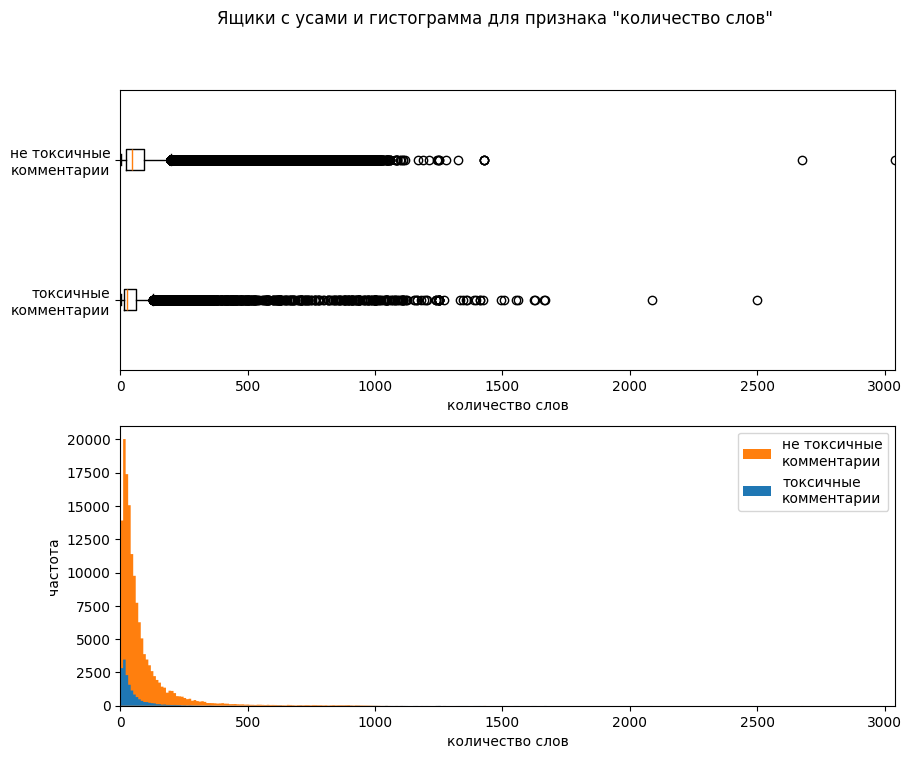

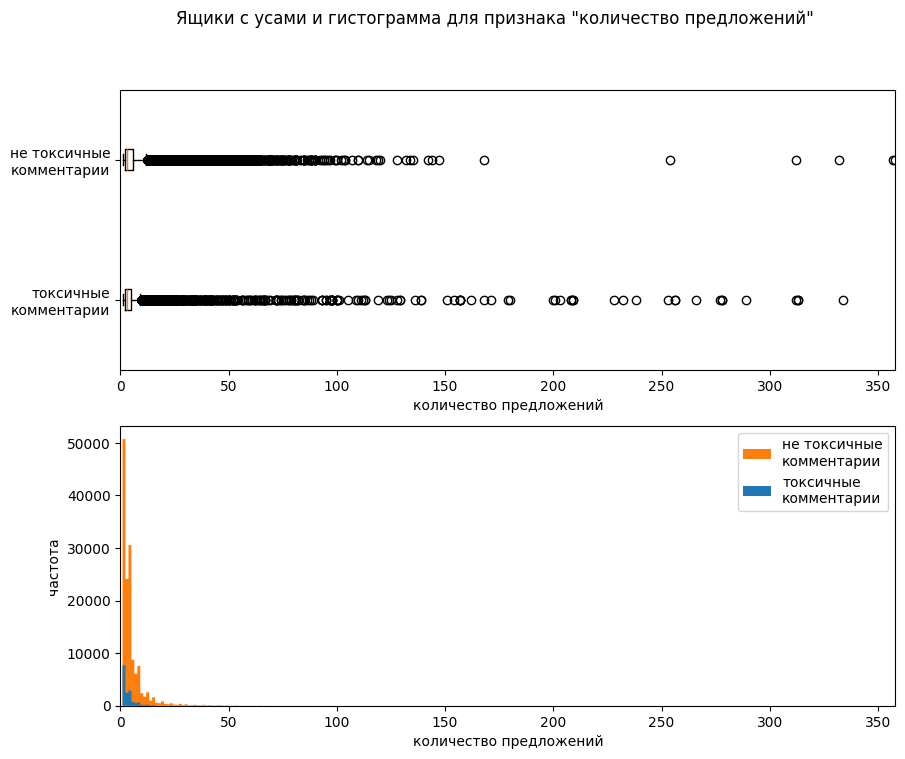

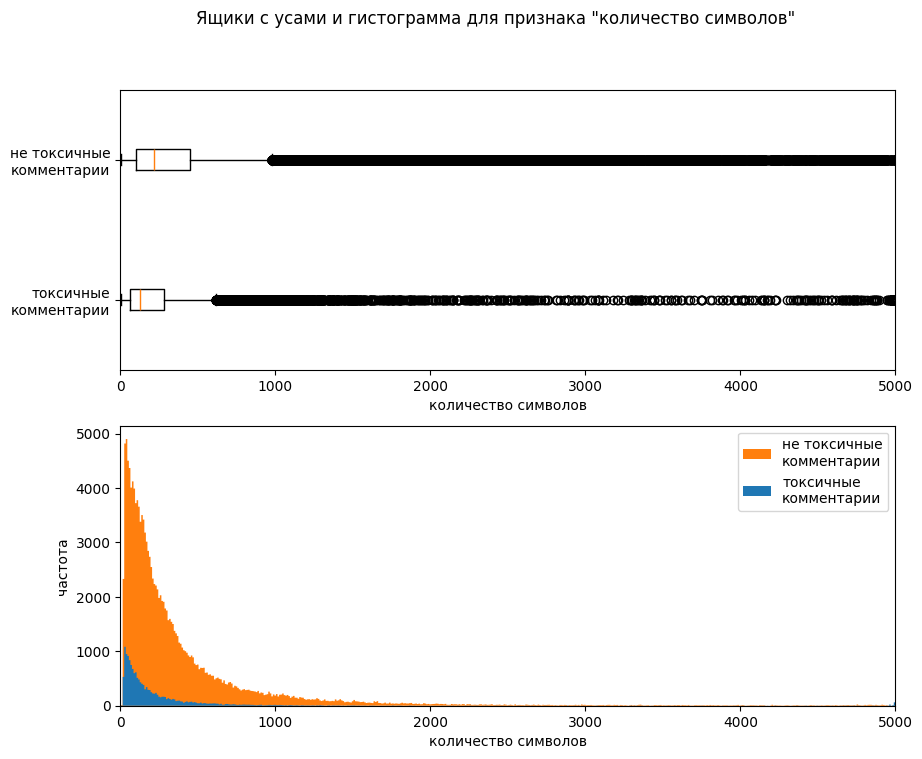

In [20]:
for col in ['word_count', 'sents_len', 'len']:
    
    distribution_plt(
        
        [df[df['toxic']==1][col], df[df['toxic']==0][col]],
        
        name_dict[col],
        
        ['токсичные\nкомментарии', 'не токсичные\nкомментарии'],
        
        1)

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Построил графики на которых отобразил распределения для токсичных и не токсичных комментариев. Видно, что аномально большие значения встречаются в обеих категориях комментариев.
        
</font></div>

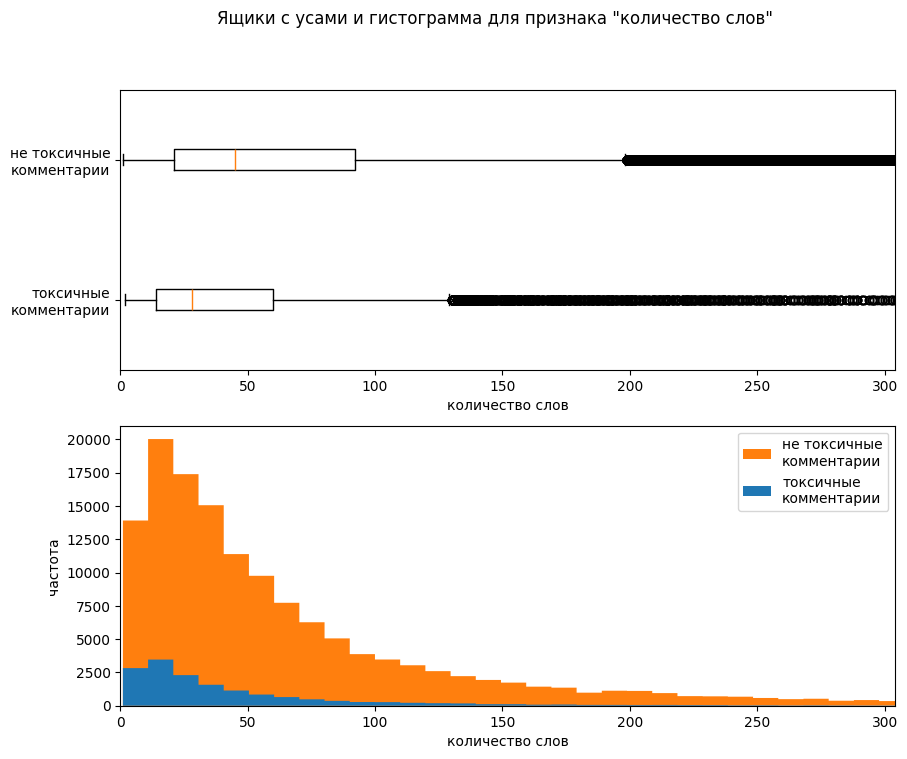

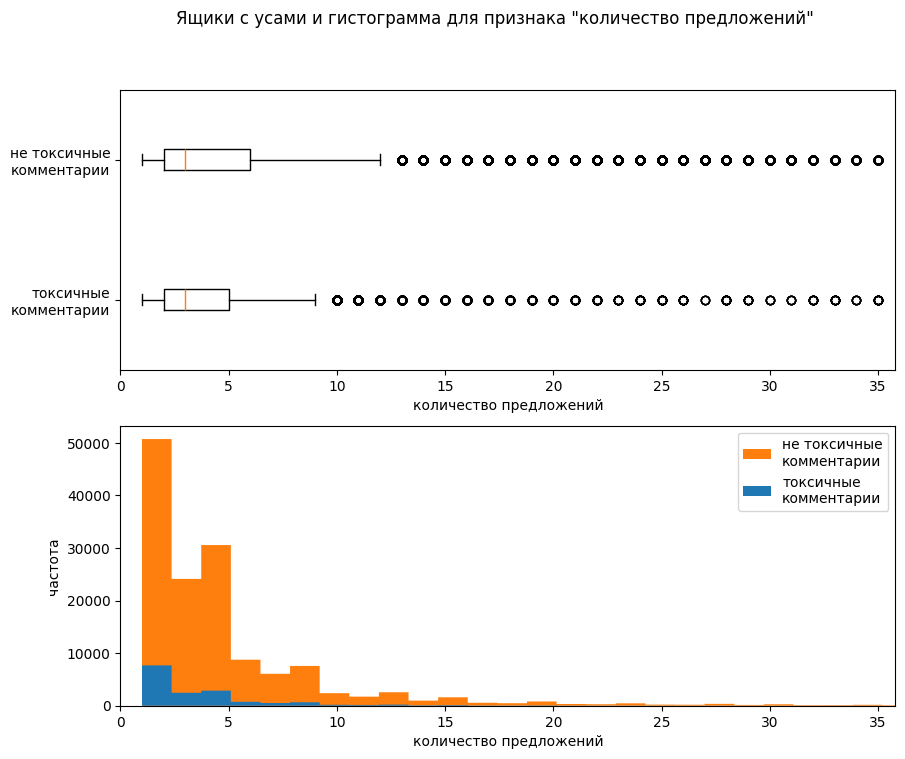

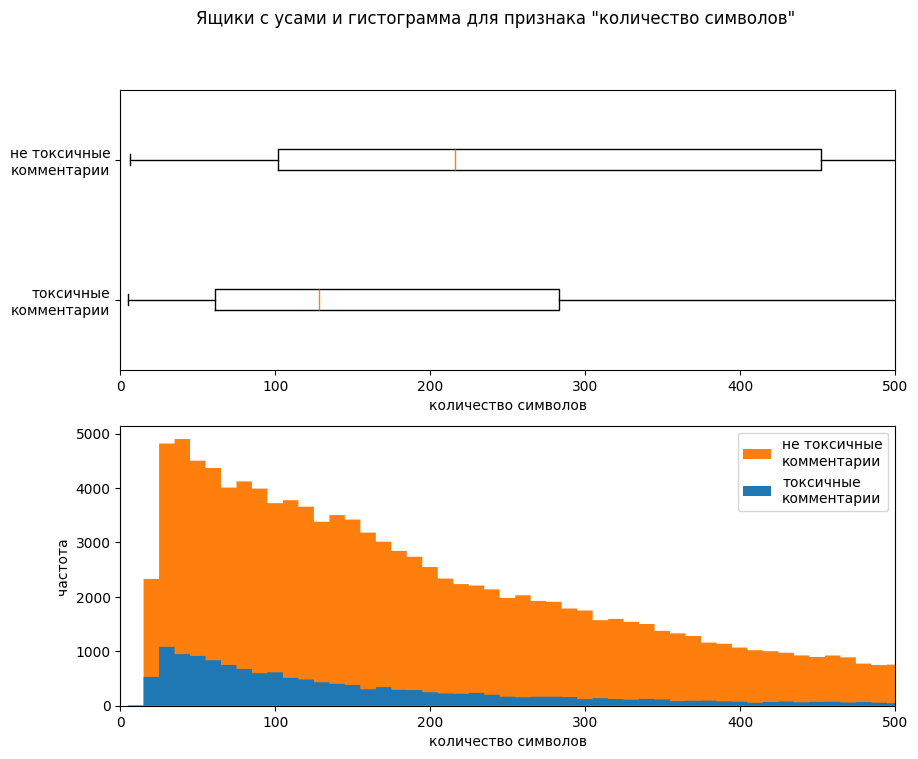

In [21]:
for col in ['word_count', 'sents_len', 'len']:
    
    distribution_plt(
        
        [df[df['toxic']==1][col], df[df['toxic']==0][col]],
        
        name_dict[col],
        
        ['токсичные\nкомментарии', 'не токсичные\nкомментарии'],
        
        0.1)

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Построил графики с лимитом для того, чтобы проще было изучить данные. Теперь можно увидеть, что:
* медианы у и квартили токсичных и не токсичных комментариев отличаются;
* не токсичные комментарии, как правило, содержат большее количество предложений, символов и слов.
        
</font></div>

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        159292 non-null  object
 1   toxic       159292 non-null  int64 
 2   sents_len   159292 non-null  int64 
 3   len         159292 non-null  int64 
 4   word_count  159292 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 6.1+ MB


In [23]:
def w_count(dataframe, df_cleaning=False, stop_words_filtered = False):

    if df_cleaning == True:
        dataframe = dataframe.str.lower()
        display('text lowered')
        dataframe = dataframe.swifter.apply(lambda x: re.sub(r'\W', ' ', x))
        display('only words in text ')
        dataframe = dataframe.swifter.apply(lambda x: re.sub(r'\s+', ' ', x))
        display('text is striped')
        
    
    word2count = {}
    
    for data in dataframe:
        words = nltk.word_tokenize(data)
        for word in words:
            if word not in word2count:
                word2count[word] = 1
            else:
                word2count[word] += 1

    if stop_words_filtered == True:
        display('stop words are removed')
        stop_words = set(stopwords.words('english'))
        filtered_word2count = {word: count for word, count in word2count.items() if word not in stop_words}
        word_freq_df = pd.DataFrame(list(filtered_word2count.items()), columns=['Word', 'Frequency'])
        word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)
    else:
        filtered_word2count = {word: count for word, count in word2count.items()}
        word_freq_df = pd.DataFrame(list(filtered_word2count.items()), columns=['Word', 'Frequency'])
        word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

    return word_freq_df

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Написал функцию для подсчета слов в датафрейме для того, чтобы можно было узнать, какие слова встераются чаще всего.
        
</font></div>

In [24]:
df_toxic = df[df['toxic']==1]
df_non_toxic = df[df['toxic']==0]#['text']

In [25]:
words_w_trash = w_count(
    df['text'],
    df_cleaning=False)

In [26]:
words_w_trash0 = w_count(
    df_non_toxic['text'],
    df_cleaning=False)

In [27]:
words_w_trash1 = w_count(
    df_toxic['text'],
    df_cleaning=False)

In [28]:
words_wo_trash = w_count(
    df['text'],
    df_cleaning=True)

'text lowered'

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

'text is striped'

In [29]:
words_wo_trash0 = w_count(
    df_non_toxic['text'],
    df_cleaning=True)

'text lowered'

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

'text is striped'

In [30]:
words_wo_trash1 = w_count(
    df_toxic['text'],
    df_cleaning=True)

'text lowered'

Pandas Apply:   0%|          | 0/16186 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/16186 [00:00<?, ?it/s]

'text is striped'

In [31]:
words_wo = w_count(
    df['text'],
    df_cleaning=True,
    stop_words_filtered=True)

'text lowered'

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

'text is striped'

'stop words are removed'

In [32]:
words_wo0 = w_count(
    df_non_toxic['text'],
    df_cleaning=True,
    stop_words_filtered = True)

'text lowered'

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

'text is striped'

'stop words are removed'

In [33]:
words_wo1 = w_count(
    df_toxic['text'],
    df_cleaning=True,
    stop_words_filtered=True)

'text lowered'

Pandas Apply:   0%|          | 0/16186 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/16186 [00:00<?, ?it/s]

'text is striped'

'stop words are removed'

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Составил несколько датафремов, которые отличаются наличием или отсутствием негативных комментариев, наличием стоп - слов и наличием символов.
        
</font></div>

In [34]:
def bars(df_list, stitle):
    
    fig, ax = plt.subplots(3,1,figsize=(12,20))
    
    ax[0].barh(df_list[0]['Word'],df_list[0]['Frequency'])
    ax[1].barh(df_list[1]['Word'],df_list[1]['Frequency'])
    ax[2].barh(df_list[2]['Word'],df_list[2]['Frequency'])

    ax[0].set_title('Все комментарии')
    ax[1].set_title('Не токсичные комментарии')
    ax[2].set_title('Токсичные комментарии')
    
    ax[0].set_ylabel('Слова')
    ax[1].set_ylabel('Слова')
    ax[2].set_ylabel('Слова')

    ax[0].set_xlabel('Количество слов')
    ax[1].set_xlabel('Количество слов')
    ax[2].set_xlabel('Количество слов')

    fig.suptitle(stitle)

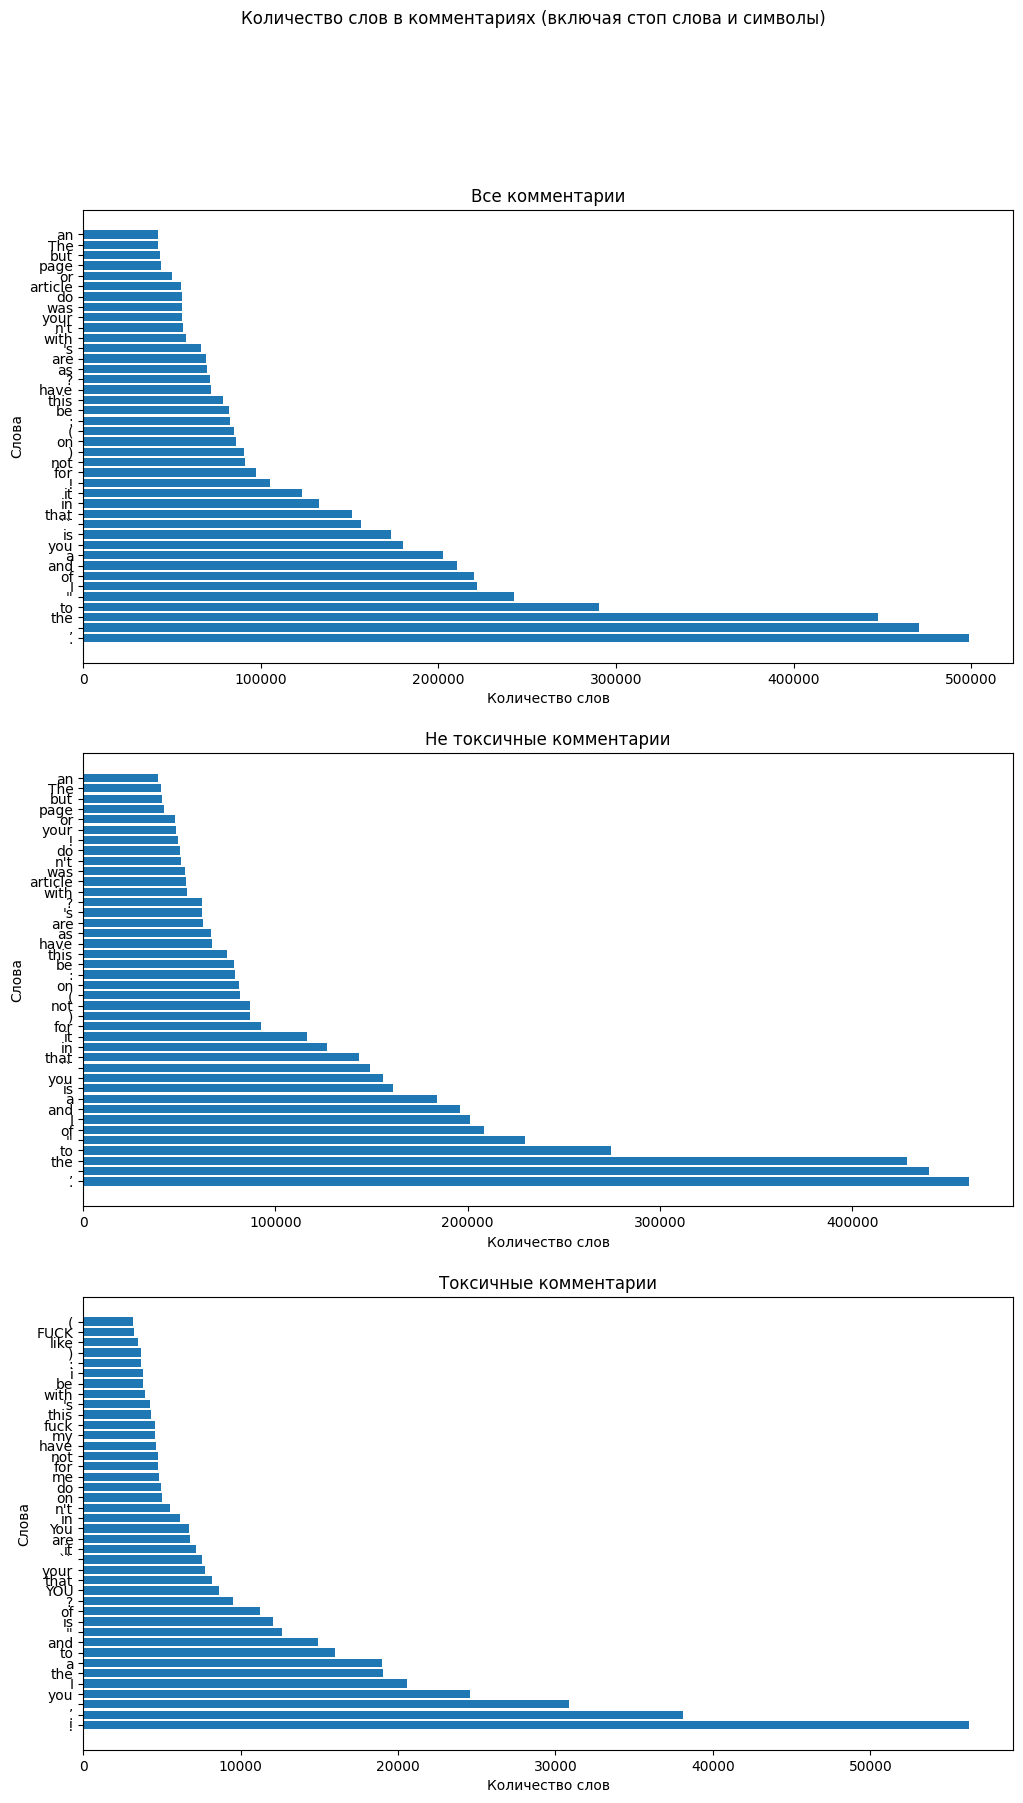

In [35]:
bars([words_w_trash.head(40),words_w_trash0.head(40),words_w_trash1.head(40)], 'Количество слов в комментариях (включая стоп слова и символы)')

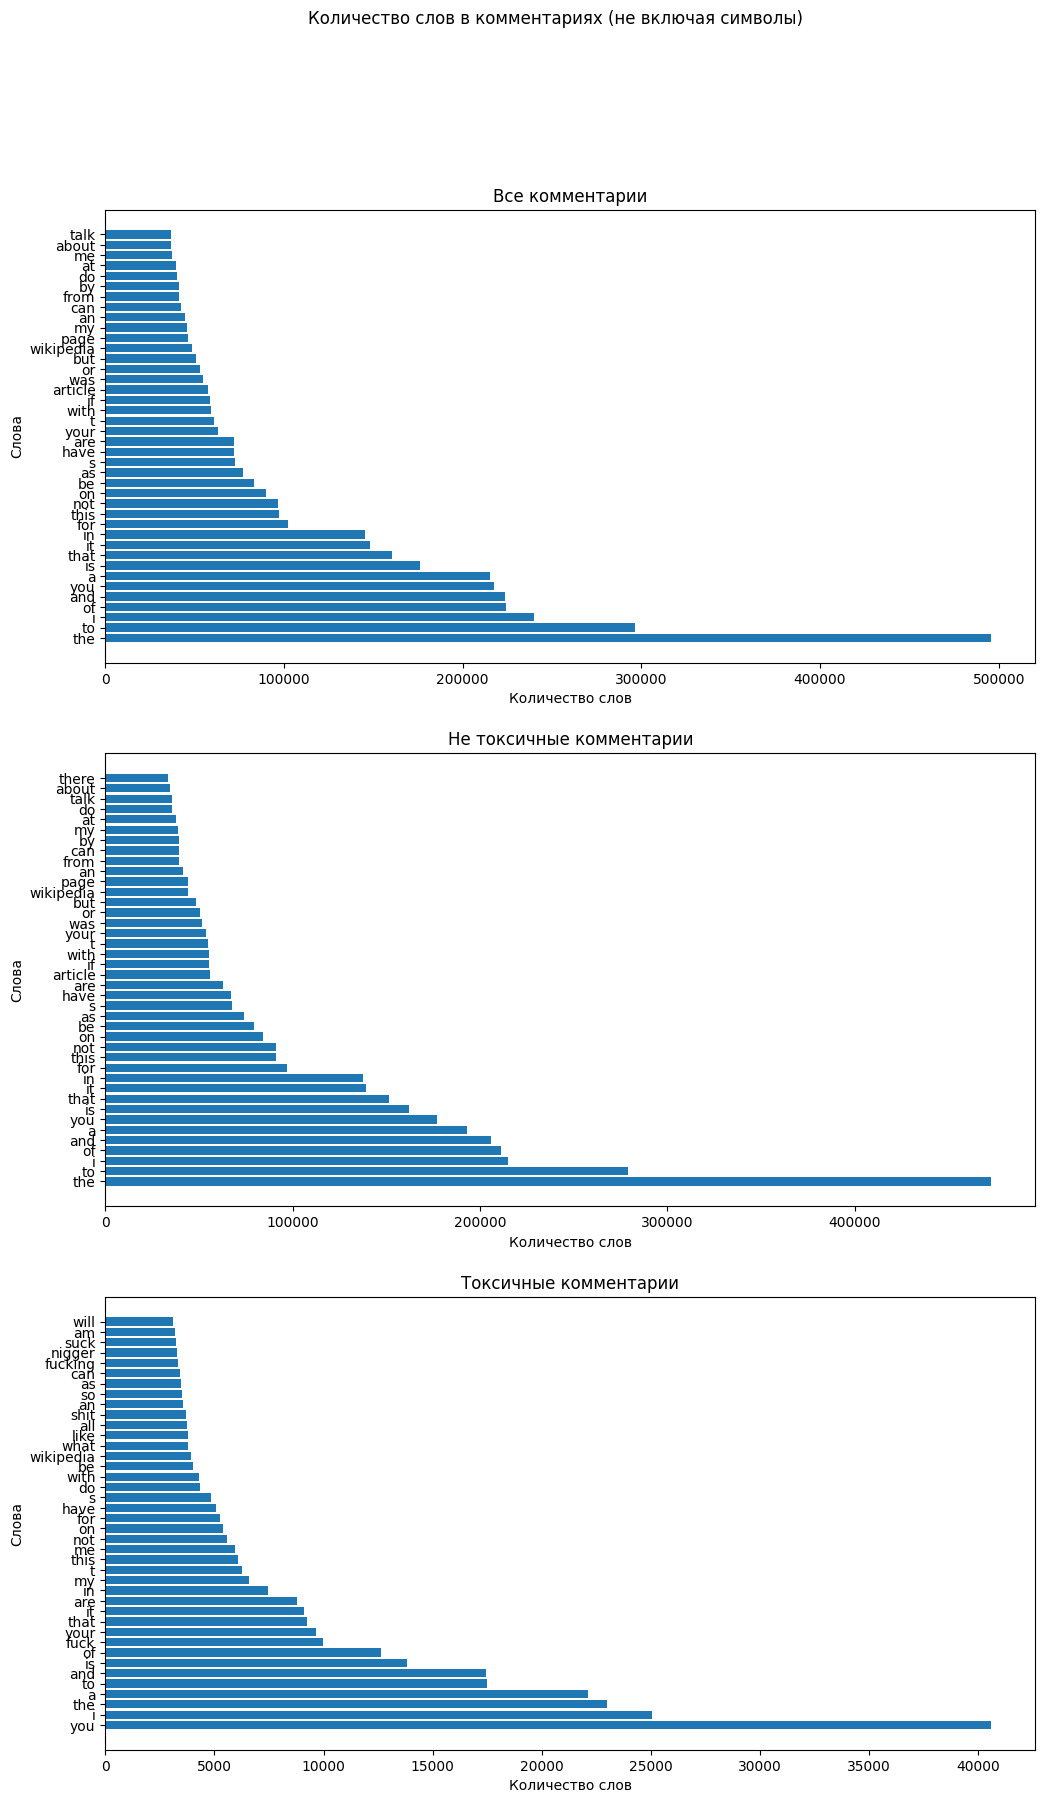

In [36]:
bars([words_wo_trash.head(40),words_wo_trash0.head(40),words_wo_trash1.head(40)], 'Количество слов в комментариях (не включая символы)')

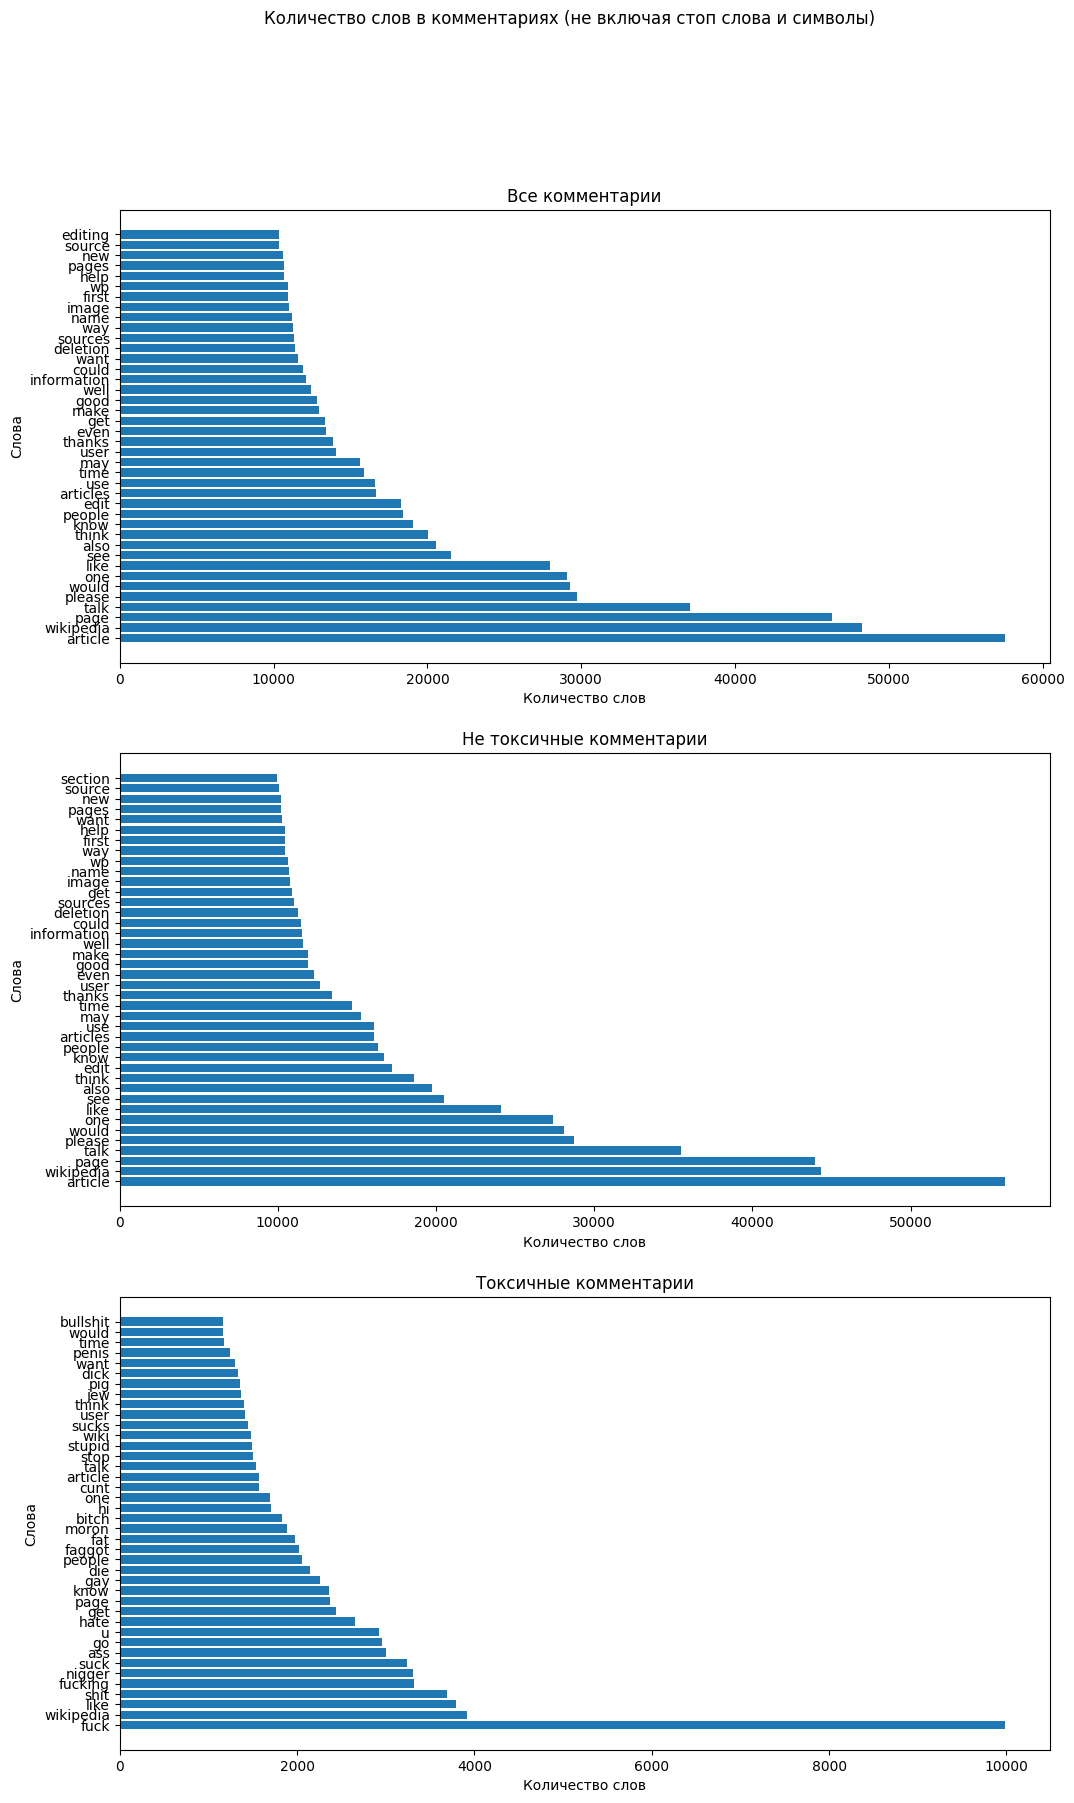

In [37]:
bars([words_wo.head(40),words_wo0.head(40),words_wo1.head(40)], 'Количество слов в комментариях (не включая стоп слова и символы)')

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Из столбчатых диаграмм, построенных выше видно, что в токсичных комментариях чаще встерчаются ругательства. Символы вроде скобок или восклицательных знаков встречаются в обеих категориях, как и стоп слова, а частота при этом разная, поэтому удалять их из текста при дальнейшей обработке стоит крайне осторожно.
       
</font></div>

In [38]:
words_w_trash0.tail(50)

,Word,Frequency
146582,soul-damning,1
146583,nation-destroying,1
146586,majoritarian,1
146590,dooms,1
146591,damns,1
146625,==Superscript,1
146627,rDNS,1
146628,RFC1912,1
146686,Fieryangel,1
146675,noze,1


In [39]:
words_w_trash1.tail(50)

,Word,Frequency
28032,Khar,1
28031,wch,1
28030,rheumatological/neurologica,1
3154,baklava,1
28028,freighted,1
28025,Ncrossman,1
28044,laser,1
28024,thimks,1
28023,86.45.211.71,1
28021,Rand,1


In [40]:
df[df['text'].str.contains('Birthday-cake-cake-cake')]

,text,toxic,sents_len,len,word_count
57666,"""\n\n Guessing you've heard it.... \n\nSo I wanna know if you want some Birthday-cake-cake-cake-cake-cake-cake-Birthday-cake-cake-cake-cake!? Because Imma make you my bitch tonight ;) Hehe (in all honesty, that song is beyond ridik) • Talk2Me """,1,3,242,43


In [41]:
df[df['text'].str.contains('f@ck', re.IGNORECASE)]

,text,toxic,sents_len,len,word_count
118152,Why is adrian such a f@cking loser??? GET A LIFE,1,2,48,15
145501,u think i get impressed by some f@ck!ng swedish @$$hole who has been on Wiki for 2 years? Hell no. Official press releases by Media outlets have been accepted for years now - and so will this one be.,1,3,199,49


<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Отобразил по 50 самых редко встретившихся слов в комментариях. Видно, что в строках могут встречаться ip адреса, url, слова, написанные с ошибками или имена. 

При ближайшем рассмотрении можно встретить комментарии с большим количеством дубликатов внутри или со матными словами, которые замаскировали символами.

   
</font></div>

In [42]:
def url_rem(string_):
    extractor = URLExtract()
    urls = extractor.find_urls(string_)
    for url in urls:
        string_ = re.sub(re.escape(url), ' XXLNK ', string_)
    
    string_ = re.sub(r'https?://\S+|www\.\S+', ' XXLNK ', string_)
    string_ = re.sub(r'<.*?>+', ' XXLNK ', string_)
    return string_

In [43]:
def mail_user_rem(string_):
    
    string_ = re.sub(r'[A-Za-z0-9\_]*@[A-Za-z]*\.?[A-Za-z0-9]*', ' XXM ', string_)
    string_ = re.sub(r'User:\S+', ' XXU ', string_)

    return string_

In [44]:
def brackets(string, symbol, symbol1):

    '''symbol - [ or { ; symbol1 - ] or } '''
    
    patt = '\\' + symbol + '+' + '|' + '\\' + symbol1 + '+'
     
    string = re.sub('\n', '. ', string)

    
    braks = re.findall(patt, string)

    if len(braks)>1:

        
        
        if braks[0]==symbol1 or braks[0]==symbol1*2:
            patt1 = '\\' + symbol1 + '+'
            string =  re.split(patt1, string, maxsplit = 1)[::-1]+[symbol1]
                
            string = ' '.join(string)
        else:
            string = string
            
        
        sub_patt = '\\' + symbol + '+' + '.*' + '\\' + symbol1 + '+'

        result = re.sub(sub_patt, ' XXBRCT ', string)        
        if result==' XXBRCT ':
            result = string
    else:
        result = string


    
    return result

In [45]:
def clean_text(string):

    flag = re.IGNORECASE
    

    string = re.sub(r'\S+#\S+',' XXH ', string)
    
    string = re.sub(r'Image:\S+', ' XXF ', string, flags=flag)
    string = re.sub(r'File:\S+', ' XXF ', string, flags=flag)
    string = re.sub(r'Category:\S+',' XXC ',string, flags=flag)
    string = re.sub(r'Talk:\S+|User_talk:\S+',' XXW ',string, flags=flag)
    string = re.sub(r'Wikipedia.*:\S+',' XXW ',string, flags=flag)
    string = re.sub(r'\S+.png',' XXF ', string, flags=flag)
    string = re.sub(r'\S+.jpeg',' XXF ', string, flags=flag)
    string = re.sub(r'\S+.jpg',' XXF ', string, flags=flag)
    string = re.sub(r'\S+.gif',' XXF ', string, flags=flag)
    string = re.sub(r'\S+.pdf',' XXF ', string, flags=flag)
    string = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' XXIP ',string) 

    string = re.sub(r'(\W)\1+|(\D)\1+', r'\1', string)
    string = re.sub(r'[\_\+\~]', ' ', string)
    string = re.sub("[”‘’“«»]", r'"', string)
    string = re.sub("\t", r' ', string)
    string = re.sub("[A-Za-z0-9]+", lambda ele: " " + ele[0] + " ", string)
    string = re.sub(r'\s+', ' ', string)
    
    return string.strip()

In [46]:
def clean_sents(string):
    string = url_rem(string)
    string = brackets(string, '[',']')
    string = brackets(string, '{','}')
    sents = nl_split(string)
    
    cl_sents = [mail_user_rem(sent) for sent in sents]

    cl_sents = [clean_text(sent) for sent in cl_sents]
    return cl_sents

In [47]:
def chunker(string):

    sents_ = clean_sents(string)

    tokenized_sents = [tokenizer.encode(sent, add_special_tokens=False) for sent in sents_]

    usents=[]
   
    for sent in tokenized_sents:
        if sent not in usents:
            usents.append(sent)
    
    if len(usents)>1:
        result = [i+[102] for i in usents] 
        result = [101] + sum(result, [])
    
    elif len(usents)==1:
        result = [101] + usents[0] + [102]
    
    #else:
    #    result = tokenizer.encode(sents_[0])

    if len(set(result))/len(result)<0.02:
        result = [5567] + list(dict.fromkeys(result)) + [5567]
        
    if len(result)>512:

        result = result[:129] + result[-382:]
        #result = result[:511] + [102]

    
    return result

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Написал ряд функций, для того, чтобы отчистить текст и привести строки к общему виду:

* Удалил url;
* Удалил почтовые адреса;
* Удалил текст в квадратных и фугурных скоках;
* Удалил наименования категорий, файлов и пр.

Так же написал функцию, которая токенизирует текст и обрезает лист из токенов до необходимой длинны в 512 токенов.

   
</font></div>

In [48]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [49]:
tokenizer

DistilBertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [50]:
tokenizer.added_tokens_encoder

{'[PAD]': 0, '[UNK]': 100, '[CLS]': 101, '[SEP]': 102, '[MASK]': 103}

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

В качестве языковой модели выбрал distilbert, так как он образует эмбеддинги быстрее и немного качественнее, чем обычные bert (в данном случае).

   
</font></div>

In [51]:
def logy(feats, target):
    lr = LogisticRegression(random_state=RANDOM_STATE,max_iter=100000,class_weight='balanced')
    lr.fit(feats, target)
    scores = cross_val_score(lr, feats, target, cv=5, scoring='f1_macro')
    return scores

## Обучение

In [52]:
samp = df.sample(n=64000, random_state=RANDOM_STATE)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    #samp[['text','orient','relig','family']],
    samp['text'],
    samp['toxic'],
    test_size = 0.5,
    random_state = RANDOM_STATE,
    stratify = samp['toxic'])

In [54]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32000,), (32000,), (32000,), (32000,))

In [55]:
class BertTokenizer(object):

    def __init__(self, text, config, batch_size=1):
        
        self.text = text
        self.batch_size = batch_size
        self.config = config
        self.model = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased', config=self.config)
    
    def get(self):


        
        tokenized = self.text.swifter.apply(lambda x: chunker(x))
        
        max_len = 0
        
        for tok in tokenized.values:
            if len(tok) > max_len:
                max_len = len(tok)

        padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
        attention_mask = np.where(padded != 0, 1, 0)
        
        batch_size = self.batch_size
        
        embeddings = []
        
        for i in notebook.tqdm(range(len(padded) // batch_size)):
                batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
                attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
                
                with torch.no_grad():
                    batch_embeddings = self.model(batch, attention_mask=attention_mask_batch)
                
                embeddings.append(batch_embeddings[0][:,0,:].numpy())
    
        features = np.concatenate(embeddings)

        return features

In [56]:
cfg_dict = {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  
  "transformers_version": "4.56.0",
  "vocab_size": 30522
}
cfg = transformers.DistilBertConfig.from_dict(cfg_dict)

In [57]:
cfg

DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "transformers_version": "4.56.0",
  "vocab_size": 30522
}

In [58]:
dembs_train = BertTokenizer(text=X_train, config = cfg, batch_size=50).get()

Pandas Apply:   0%|          | 0/32000 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (864 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/640 [00:00<?, ?it/s]

In [59]:
logy(dembs_train, y_train.values)

array([0.82033235, 0.81225359, 0.81055264, 0.80250997, 0.81211471])

In [60]:
dembs_test = BertTokenizer(text=X_test,config = cfg, batch_size=50).get()

Pandas Apply:   0%|          | 0/32000 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

In [61]:
def f1_eval(y_true, y_pred,):

    f1 = f1_score(y_pred, y_true, average=None)[1]
    return f1

In [62]:
def f1_xgb(y_pred, dtrain):
    y_true = dtrain.get_label()
    f1 = f1_score( y_pred,y_true, average=None)[1]

    return 'f1', f1

In [63]:
from sklearn.metrics import make_scorer
my_func = make_scorer(f1_eval, greater_is_better=True)

In [64]:
pipe = Pipeline([('models',[LogisticRegression(random_state=RANDOM_STATE,class_weight='balanced')])])

In [65]:
p_wei = y_train.value_counts()[0]/y_train.value_counts()[1]

In [66]:
param_grid = [

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, class_weight='balanced', verbose=2)],
        'models__solver': ['newton-cg', 'liblinear']
        
    },

    {
        'models': [XGBClassifier(
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            verbosity=2,
            scale_pos_weight = p_wei
            
            )],
        'models__n_estimators':[2000],
        'models__max_depth':[4],
        'models__learning_rate':[0.05, 0.1],
        'models__reg_alpha':[ 0.1, 1],
        'models__reg_lambda':[1.5, 1],        
        
        
    }

]

In [67]:
grid_search = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5,
    scoring=my_func,
    verbose=3,
    n_jobs=-1
)
grid_search.fit(dembs_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[17:03:16] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (32000, 768, 24576000).


,estimator,Pipeline(step..._state=88)])])
,param_grid,"[{'models': [LogisticRegre...88, verbose=2)], 'models__solver': ['newton-cg', 'liblinear']}, {'models': [XGBClassifier...ree=None, ...)], 'models__learning_rate': [0.05, 0.1], 'models__max_depth': [4], 'models__n_estimators': [2000], ...}]"
,scoring,make_scorer(f...hod='predict')
,n_jobs,-1
,refit,True
,cv,5
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [68]:
pd.DataFrame(grid_search.cv_results_)[['rank_test_score', 'mean_test_score','params']].sort_values('rank_test_score').head()

,rank_test_score,mean_test_score,params
4,1,0.734584,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.05, 'models__max_depth': 4, 'models__n_estimators': 2000, 'models__reg_alpha': 1, 'models__reg_lambda': 1.5}"
3,2,0.734337,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.05, 'models__max_depth': 4, 'models__n_estimators': 2000, 'models__reg_alpha': 0.1, 'models__reg_lambda': 1}"
5,3,0.732195,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.05, 'models__max_depth': 4, 'models__n_estimators': 2000, 'models__reg_alpha': 1, 'models__reg_lambda': 1}"
6,4,0.731660,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.1, 'models__max_depth': 4, 'models__n_estimators': 2000, 'models__reg_alpha': 0.1, 'models__reg_lambda': 1.5}"
8,5,0.731570,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.1, 'models__max_depth': 4, 'models__n_estimators': 2000, 'models__reg_alpha': 1, 'models__reg_lambda': 1.5}"


In [69]:
grid_pred = grid_search.best_estimator_.predict(dembs_test)

In [70]:
f1_score(grid_pred, y_test)

0.7287268074216251

In [71]:
print(classification_report(grid_pred, y_test))
#print(classification_report(grid_pred, test_samp['toxic']))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     29041
           1       0.69      0.77      0.73      2959

    accuracy                           0.95     32000
   macro avg       0.83      0.87      0.85     32000
weighted avg       0.95      0.95      0.95     32000



In [73]:
classifier_tuned_threshold = TunedThresholdClassifierCV(
    grid_search.best_estimator_, scoring=my_func, n_jobs=-1
).fit(dembs_train, y_train)

[17:05:01] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (32000, 768, 24576000).


In [74]:
ctt_pred = classifier_tuned_threshold.predict(dembs_test)

In [75]:
classifier_tuned_threshold.best_threshold_

0.44444447400966386

In [76]:
f1_score(y_test, ctt_pred)

0.7278975320212434

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

После подбора модели при помощи gridsearch удалось достичь только значения метрики f1 равное 0.73 без учета соотношения целевого признака. Автоматический подбор порога классификации необходимого результата тоже не дал. 


</font></div>

## Выводы

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

В ходе проета были решены следующие задачи:


* подготовлены данные, которые нам предоставил заказчик;
* проведен анализ полученных данных;
* построена модель, качество которой (почти) будет удовлетворять требованиям заказчика.




   
</font></div>

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны